In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from root_numpy import root2array
from scipy.optimize import curve_fit
from lmfit import  Model #better gaussian model

In [33]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

anatypes = ['SingleMuonMCTrack',#'MCBNBRecoTrack',
            'MCBNBSelectedRecoTrack','DataBNBSelectedRecoTrack']

In [34]:
titles = { 
           'SingleMuonMCTrack'        : 'Fully Contained Single Muon MCTracks',
           'SingleMuonRecoTrack'      : 'Fully Contained, Well Reconstructed Single Muon Tracks',
           'DataBNBSelectedRecoTrack' : 'Selected, Well Reconstructed Tracks from NumuCC Data',
           'MCBNBSelectedRecoTrack'   : 'Selected, Well Reconstructed Tracks from NumuCC Simulation',
           'MCBNBRecoTrack'           : 'MC numuCC BNB Truth-Selected, Well Reconstructed Tracks',
           'full_MCS_energy'          : 'MCS Total Energy [GeV]',
           'full_range_energy'        : 'Range-Based Total Energy [GeV]',
           'full_MCS_momentum'        : 'MCS Momentum [GeV]',
           'full_range_momentum'      : 'Range-Based Momentum [GeV]',
           'true_E'                   : 'True Total Energy [GeV]'
         }

latextitles = {
           'full_range_energy'   : 'E_{Range}',
           'full_range_momentum' : 'p_{Range}',
           'full_MCS_energy'     : 'E_{MCS}',
           'full_MCS_momentum'   : 'p_{MCS}',
           'true_E'              : 'E_{True}'
         }

In [35]:
seglen = 10
filedir = 'anafiles/'

df_dict = {}

for anatype in anatypes:
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
    #This df has track-by-track information (MCS energy, range energy, etc)
    df_dict[anatype] = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
  
    #Optional driver DF tree that holds some MCTrack information
    driverdf = pd.DataFrame( root2array ( filedir + myfile, 'driver_tree' ) )
    #Merge it into the main df by run,subrun,eventid
    df_dict[anatype] = df_dict[anatype].merge(driverdf, on=['run','subrun','eventid'])

In [36]:
#Read in handscan info if working with data
filedir = 'handscan_results/'
myfile = 'handscan_results_kaleko.csv'

hsdf = pd.read_csv(filedir + myfile,index_col=False)
   
#Column names with spaces are hard to deal with, this is easy
cols = hsdf.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
hsdf.columns = cols

#If no optional comments were typed in it shows up as NaN
#Let's just make a column of "optional comments present" (boolean)

hsdf['comments_present'] = hsdf['optional_comments'].notnull()

#Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0

#maybe bad is either definitely_bad, or if comments are present (more conservative)
hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']

print "total length of hsdf is",len(hsdf)
print "number of definitely bad is",len(hsdf.query('definitely_bad'))
print "number of maybe bad is",len(hsdf.query('maybe_bad'))

#let's rename run, subrun, eventid columns to match the MCS df
#for now just make a new column because it's easier
hsdf['run'] = hsdf['Run']
hsdf['subrun'] = hsdf['Subrun']
hsdf['eventid'] = hsdf['Event_ID']

df_dict['DataBNBSelectedRecoTrack'] = df_dict['DataBNBSelectedRecoTrack']\
                                        .merge(hsdf, on=['run','subrun','eventid'])


total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [37]:
#reco-true/true
def fractional_bias_plots(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', plot_bin_distributions = False, extraquery = None):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
        
    for anatype in anatypes:
     
        myreses, mystds, myerrs = [], [], []
        
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)

            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs,fmt='o--',label='%s' % titles[anatype])
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias for Various Input Types',fontsize=16)
    t.set_y(1.04) 
    if write_figures:
        plt.tight_layout()
        print " Saving figure!",figdir+'MCS_range_bias_multiplesamples.png'
        plt.savefig(figdir + 'MCS_range_bias_multiplesamples.png')

 Saving figure! Figures/MCS_range_bias_multiplesamples.png


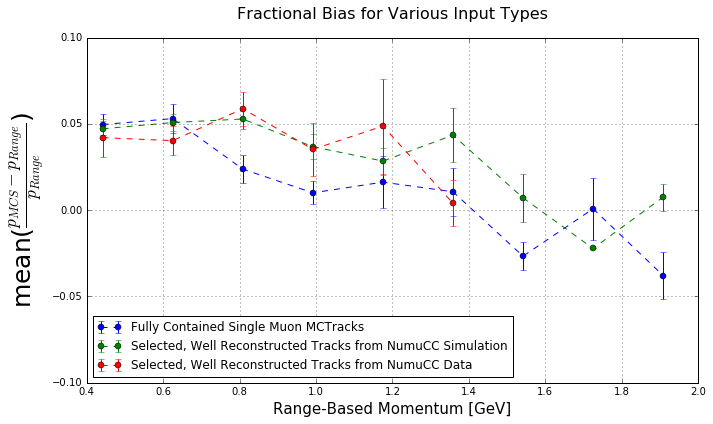

In [38]:
fractional_bias_plots(xvar='full_range_momentum',xbins=np.linspace(0.35,2,10))
blah = plt.ylim((-.1,.1))


In [39]:
def fractional_resolution_plots(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', plot_bin_distributions = False, extraquery = None):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
        
    for anatype in anatypes:
     
        myreses, mystds, myerrs = [], [], []
        
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
            
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
                
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( 2 * float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='%s' % titles[anatype])
    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('MCS Momentum Resolution for Various Input Types',fontsize=16)
    t.set_y(1.04) 
    if write_figures:
        plt.tight_layout()
        print " Saving figure!",figdir+'MCS_range_resolution_multiplesamples.png'
        plt.savefig(figdir + 'MCS_range_resolution_multiplesamples.png')

 Saving figure! Figures/MCS_range_resolution_multiplesamples.png


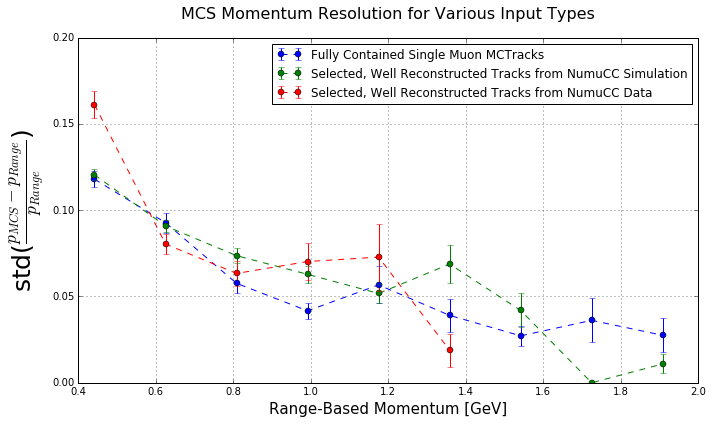

In [40]:
fractional_resolution_plots(xvar='full_range_momentum',xbins=np.linspace(0.35,2,10))
blah = plt.ylim((0,0.20))